In [1]:
import re
import json
import pickle
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data_folder = './data'
model_folder = './model'

main_dataset = 'train_compas_processed.xlsx'

model_file_name = 'rf_recidivism_prediction.sav'
#processed_data_file_name = 'compas_processed.xlsx'

In [5]:
test_set_percent = 0.1

In [6]:
df_init = pd.read_excel (data_folder+'/'+main_dataset)
df = df_init

In [7]:
df.shape

(8918, 14)

In [8]:
df.head()

,sex,age,age_cat,race,decile_score,priors_count,days_b_screening_arrest,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,juv_count,c_cat,weapon_firearm
0,Female,22,Less than 25,African-American,9,2,-1,1,F,0,0,1,battery,True
1,Male,22,Less than 25,Caucasian,4,0,-1,1,M,0,0,0,battery,False
2,Male,46,Greater than 45,African-American,9,2,-1,1,F,0,0,0,grand theft,False
3,Male,66,Greater than 45,Caucasian,1,1,-1,1,M,0,0,0,no charge,False
4,Male,51,Greater than 45,Caucasian,2,2,-23,23,F,0,0,0,other,False


In [9]:
df.columns

Index(['sex', 'age', 'age_cat', 'race', 'decile_score', 'priors_count',
       'days_b_screening_arrest', 'c_days_from_compas', 'c_charge_degree',
       'is_recid', 'is_violent_recid', 'juv_count', 'c_cat', 'weapon_firearm'],
      dtype='object')

### Model training

In [10]:
drop_first = False

feat2dummie = ['sex','age_cat','race','c_charge_degree','c_cat','weapon_firearm']

for i in feat2dummie:
    one_hot = pd.get_dummies(df[i], prefix=i, drop_first=drop_first)
    df = df.drop(i,axis = 1)
    df = df.join(one_hot)
    
is_recid, is_violent_recid = df['is_recid'], df['is_violent_recid']

columns_to_drop = ['is_recid', 'is_violent_recid']
df = df.drop(columns_to_drop, axis=1)

In [11]:
df.head(10)

,age,decile_score,priors_count,days_b_screening_arrest,c_days_from_compas,juv_count,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,c_cat_assault,c_cat_battery,c_cat_burglary,c_cat_cannabis,c_cat_driving,c_cat_grand theft,c_cat_lewdness,c_cat_mischief,c_cat_no charge,c_cat_other,c_cat_poss,c_cat_resisting,c_cat_sexual,c_cat_tampering,weapon_firearm_False,weapon_firearm_True
0,22,9,2,-1,1,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,22,4,0,-1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,46,9,2,-1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,66,1,1,-1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,51,2,2,-23,23,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,28,5,10,-20,20,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
6,29,7,5,-1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
7,27,10,7,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,48,1,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
9,45,1,2,-1,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [12]:
dft = df.copy()#df.drop('c_days_from_compas', axis=1)
cols_to_pow = ['age','decile_score','priors_count','juv_count']

max_pow = 3
for k,i in enumerate(cols_to_pow):
    for j in range(1, max_pow):
        dft[i+str(j+1)] = pow(df[i], j+1)
    

In [13]:
#dft = df.drop(['decile_score','days_b_screening_arrest'], axis=1)

In [14]:
train, test, train_y, test_y = train_test_split(dft,
                                                is_recid,
                                                test_size = test_set_percent,
                                                random_state = 42)

In [15]:
# Save splitted data to data folder

train.to_csv(data_folder + '/' + 'train_x.csv', index = None, header=True)
test.to_csv(data_folder + '/' + 'test_x.csv', index = None, header=True)
train_y.to_csv(data_folder + '/' + 'train_y.csv', index = None, header=True)
test_y.to_csv(data_folder + '/' + 'test_y.csv', index = None, header=True)

In [16]:
rfc =  RandomForestClassifier(n_estimators=100,
                               oob_score=True,
                               random_state=42)
rfc.fit(train, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [17]:
pred = rfc.predict(test)
#print ("AUC-ROC (oob) = ", roc_auc_score(train_y, model.oob_prediction_))
print ("AUC-ROC (test) = ", roc_auc_score(test_y, pred))

AUC-ROC (test) =  0.5959435626102292


#### Now we'll tune parameters

In [18]:
from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [19]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [200] #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200]}


In [20]:
rfc_new = RandomForestClassifier()

rfcCV = RandomizedSearchCV(estimator = rfc_new, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
#rfcCV.fit(train, train_y)

In [21]:
#rfcCV.best_params_

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [200] #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 15, num = 5)]
max_depth.append(None)
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [1, 4, 8, 11, 15, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [4, 8, 12],
 'min_samples_split': [10, 20, 30],
 'n_estimators': [200]}


In [23]:
rfc_new = RandomForestClassifier()

rfcCV = RandomizedSearchCV(estimator = rfc_new, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
#rfcCV.fit(train, train_y)

In [24]:
#rfcCV.best_params_

In [25]:
# rfc2 =  RandomForestClassifier(n_estimators=500,
#                                oob_score=True,
#                                random_state=42,
#                              bootstrap=rfcCV.best_params_['bootstrap'],
#                              max_depth=rfcCV.best_params_['max_depth'],
#                              max_features=rfcCV.best_params_['max_features'],
#                              min_samples_leaf=rfcCV.best_params_['min_samples_leaf'],
#                              min_samples_split=rfcCV.best_params_['min_samples_split'])
# rfc2.fit(train, train_y)

In [26]:
#pred = rfc2.predict(test)

#print ("AUC-ROC (test) = ", roc_auc_score(test_y, pred))

## The best model was with default parameters

In [27]:
train.shape

(8026, 43)

In [28]:
train.columns

Index(['age', 'decile_score', 'priors_count', 'days_b_screening_arrest',
       'c_days_from_compas', 'juv_count', 'sex_Female', 'sex_Male',
       'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_F', 'c_charge_degree_M', 'c_cat_assault',
       'c_cat_battery', 'c_cat_burglary', 'c_cat_cannabis', 'c_cat_driving',
       'c_cat_grand theft', 'c_cat_lewdness', 'c_cat_mischief',
       'c_cat_no charge', 'c_cat_other', 'c_cat_poss', 'c_cat_resisting',
       'c_cat_sexual', 'c_cat_tampering', 'weapon_firearm_False',
       'weapon_firearm_True', 'age2', 'age3', 'decile_score2', 'decile_score3',
       'priors_count2', 'priors_count3', 'juv_count2', 'juv_count3'],
      dtype='object')

In [29]:
train[:1].to_excel(data_folder+'/model_colums_sample.xlsx', sheet_name='sheet1', index=False)

In [30]:
{'bootstrap': [True],
 'max_depth': [1, 4, 8, 11, 15, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [4, 8, 12],
 'min_samples_split': [10, 20, 30],
 'n_estimators': [200]}

{'bootstrap': [True],
 'max_depth': [1, 4, 8, 11, 15, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [4, 8, 12],
 'min_samples_split': [10, 20, 30],
 'n_estimators': [200]}

In [31]:
rfc =  RandomForestClassifier(n_estimators=100,
                               oob_score=True,
                               random_state=42,
                             max_depth=8,
                             min_samples_leaf=4,
                             min_samples_split=20)
rfc.fit(train, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [32]:
pred = rfc.predict(test)

print ("AUC-ROC (test) = ", roc_auc_score(test_y, pred))

AUC-ROC (test) =  0.5912169312169313


In [33]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [34]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [35]:
pred2 = rfc.predict(train)

Confusion matrix, without normalization
[[4821  509]
 [1565 1131]]
Normalized confusion matrix
[[0.90450281 0.09549719]
 [0.58048961 0.41951039]]


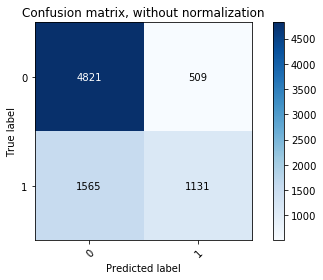

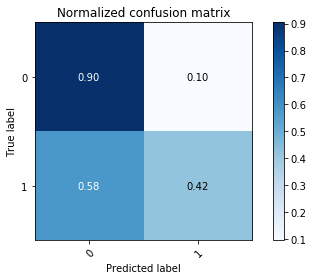

In [36]:
# Plot non-normalized confusion matrix
class_names = np.array(['0','1'])
plot_confusion_matrix(train_y, pred2, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(train_y, pred2, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[489  78]
 [221 104]]
Normalized confusion matrix
[[0.86243386 0.13756614]
 [0.68       0.32      ]]


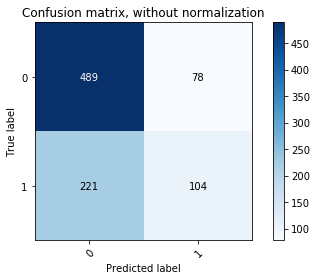

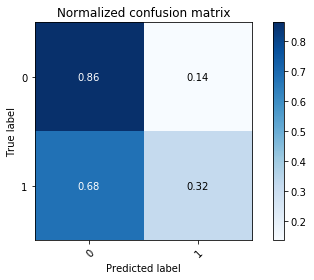

In [37]:
# Plot non-normalized confusion matrix
class_names = np.array(['0','1'])
plot_confusion_matrix(test_y, pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_y, pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [40]:
len(pred)

892

In [41]:
dft['prediction'] = rfc.predict(dft)
dft['is_recid'] = is_recid

Confusion matrix, without normalization
[[5310  587]
 [1786 1235]]
Normalized confusion matrix
[[0.90045786 0.09954214]
 [0.59119497 0.40880503]]


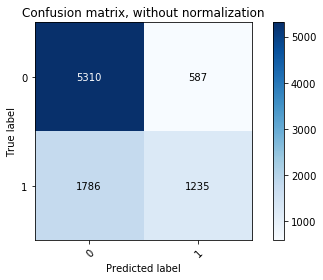

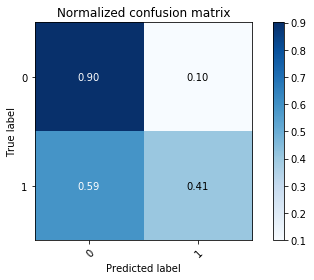

In [45]:
# Plot non-normalized confusion matrix
class_names = np.array(['0','1'])
plot_confusion_matrix(dft['is_recid'], dft['prediction'], classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(dft['is_recid'], dft['prediction'], classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [42]:
# rfc = RandomForestClassifier(n_estimators=100,
#                                oob_score=True,
#                                random_state=42)
# rfc.fit(dft, is_recid)

### Save trained model

In [43]:
# save the model to disk
pickle.dump(rfc, open(model_folder+'/'+model_file_name, 'wb'))

In [47]:
dft.to_excel(data_folder + '/' + 'compas_processed_with_results.xlsx', index = None, header=True)